<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Разделение-на-обучающую-и-тестовую-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение на обучающую и тестовую выборки</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Гребневая-регрессия" data-toc-modified-id="Гребневая-регрессия-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Гребневая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг-с-помощью-LightGBM" data-toc-modified-id="Градиентный-бустинг-с-помощью-LightGBM-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Градиентный бустинг с помощью LightGBM</a></span></li><li><span><a href="#Градиентный-бустинг-с-помощью-CatBoost" data-toc-modified-id="Градиентный-бустинг-с-помощью-CatBoost-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Градиентный бустинг с помощью CatBoost</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#RMSE-на-тестовой-выборке" data-toc-modified-id="RMSE-на-тестовой-выборке-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>RMSE на тестовой выборке</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li></ul></li></ul></div>

## Подготовка

Импортируем необходимые библиотеки.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Загрузим данные.

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df = df.sort_index()

In [5]:
df.index.is_monotonic

True

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


- В нашем распоряжении данные с 1 марта по 31 августа 2018 года. 
- Имеется 26496 наблюдений. Временной интервал - 10 минут.
- Пропусков не обнаружено.

Построим график по имеющимся данным.

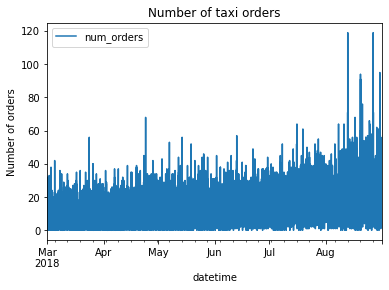

In [8]:
df.plot()
plt.title('Number of taxi orders')
plt.ylabel('Number of orders')
plt.show()

Выполним ресемплирование по одному часу, возьмем сумму заказов за час.

In [9]:
df = df.resample('1H').sum()

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод:**
1. В нашем распоряжении данные с 1 марта по 31 августа 2018 года.
2. После ресемплирования имеем 4416 строк. Интервал - 1 час.

## Анализ

Сначала взглянем на наш временной ряд.

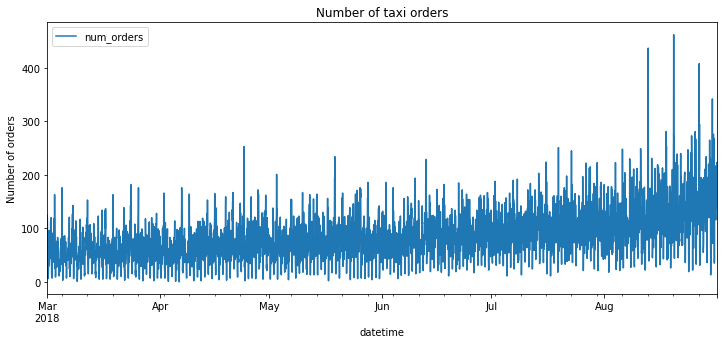

In [12]:
df.plot(figsize=(12,5))
plt.title('Number of taxi orders')
plt.ylabel('Number of orders')
plt.show()

Из-за маленького интервала сложно делать какие-либо выводы. Построим график скользящего среднего. За ширину окна возьмем 1 день или 24 часа.

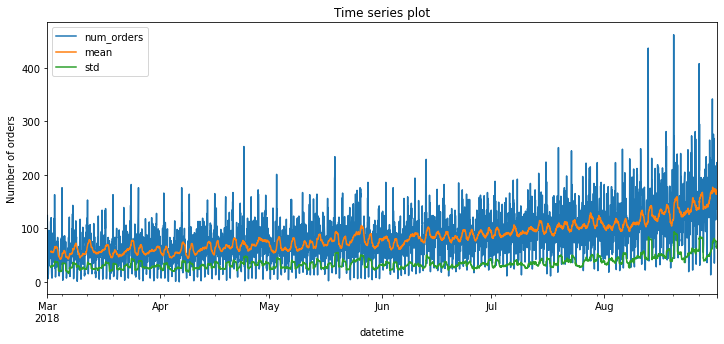

In [13]:
df_rolling = df.copy()
df_rolling['mean'] = df_rolling['num_orders'].shift().rolling(24).mean()
df_rolling['std'] = df_rolling['num_orders'].shift().rolling(24).std()
df_rolling.plot(figsize=(12,5))
plt.ylabel('Number of orders')
plt.title('Time series plot')
plt.show()

По скользящему среднему уже заметен тренд, что количество заказов такси росло с марта по август. Ряд нестационарный.

Разложим временной ряд на три составляющие: тренд, сезонность и остатки.

In [14]:
decomposed_data = seasonal_decompose(df)

Посмотрим на тренд.

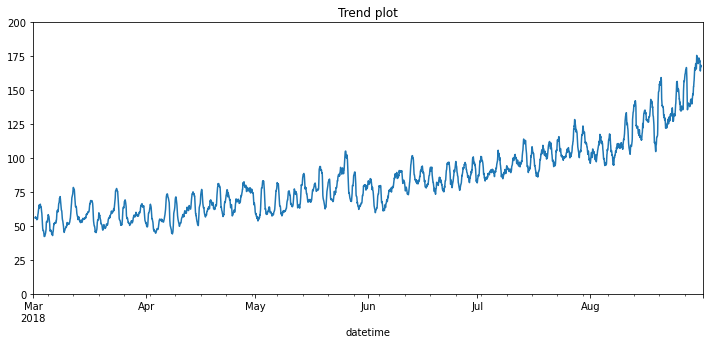

In [15]:
decomposed_data.trend.plot(figsize=(12,5))
plt.title('Trend plot')
plt.ylim(0, 200)
plt.show()

Тренд похож на скользящее среднее. По графику можно заключить, что количество заказов растет от месяца к месяцу.

Теперь взяглнем на сезонность.

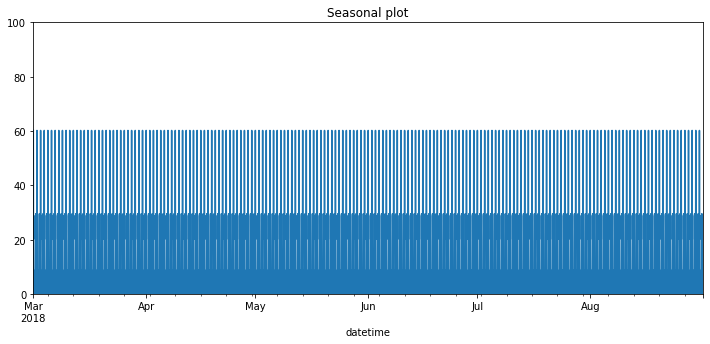

In [16]:
decomposed_data.seasonal.plot(figsize=(12,5))
plt.title('Seasonal plot')
plt.ylim(0, 100)
plt.show()

Нужно взглянуть на срез. Посмотрим на последнюю неделю августа.

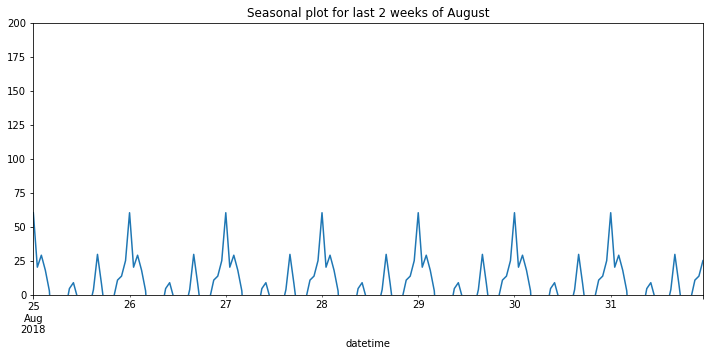

In [17]:
decomposed_data.seasonal['2018-08-25':'2018-08-31'].plot(figsize=(12,5))
plt.title('Seasonal plot for last 2 weeks of August')
plt.ylim(0, 200)
plt.show()

Можно заключить, что в течение дня есть 3 пика разной величины. Также видно, что день недели не влияет на сезонную составляющую временного ряда. Уменьшим срез, чтобы увидеть, какое время в течение дня соответствует пикам.

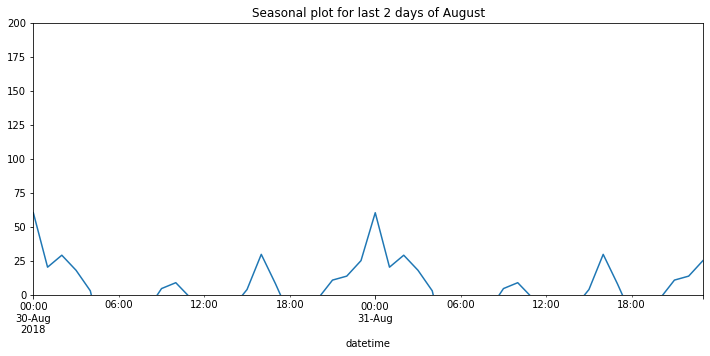

In [18]:
decomposed_data.seasonal['2018-08-30':'2018-08-31'].plot(figsize=(12,5))
plt.title('Seasonal plot for last 2 days of August')
plt.ylim(0, 200)
plt.show()

Первый пик лежит около 10 часов. Это связано с тем, что люди едут на работу в это время. Второй пик лежит около 17 часов, то есть когда люди едут с работы. Третий пик приходится на ночь, скорее всего это связано с тем, что общественный транспорт не ходит ночью.

Теперь посмотрим на остатки.

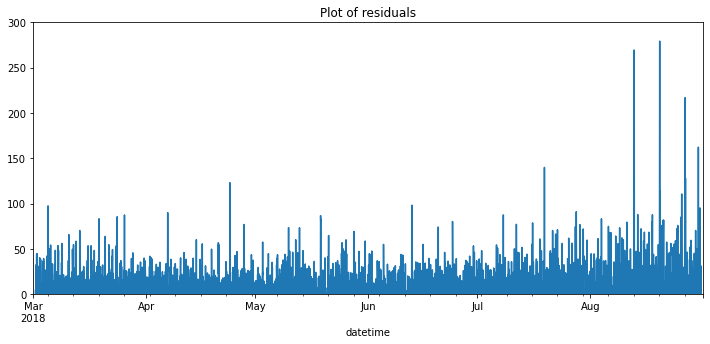

In [19]:
decomposed_data.resid.plot(figsize=(12,5))
plt.title('Plot of residuals')
plt.ylim(0, 300)
plt.show()

Временной ряд довольно сильно зашумлен.

**Вывод:**
1. Временной ряд нестационарный. Он имеет восходящий тренд, то есть количество заказов росло с марта по август.
2. Сезонность не зависит от дня недели, однако зависит от часа. Есть три пика в течение дня. Первый пик лежит около 10 часов. Это связано с тем, что люди едут на работу в это время. Второй пик лежит около 17 часов, то есть когда люди едут с работы. Третий пик приходится на ночь, скорее всего это связано с тем, что общественный транспорт не ходит ночью.
3. Временной ряд довольно сильно зашумлен.

## Обучение

Для обучения временных рядов крайне важно корректно определить признаки, а также найти оптимальные гиперпараметры моделей. Всё это нужно сделать на обучающей выборке. Поэтому мы сначала разобьем набор данных на обучающую и тестовую выборки. Затем попробуем посоздавать разные признаки на обучающей выборке и посмотреть их влияние на результат с помощью валидации. После этого мы создадим признаки и для тестовой выборки, обучим модель с оптимальными гиперпараметрами и проверим ее производительность на тесте.

### Разделение на обучающую и тестовую выборки

Выделим тестовую выборку таким образом, чтобы она составляла 10% от исходных данных.

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Выполним проверку.

In [21]:
print(train.shape)
print(test.shape)

(3974, 1)
(442, 1)


### Создание признаков

То, какие именно признаки мы выделим, оказывает сильное воздействие на результат работы модели. Чтобы найти наилучший способ, нужно попробовать много разных способов выделения признаков. Для этого мы создадим класс, создающий признаки, а затtv оптимизируем параметры данного класса на простой модели.

Создадим класс, создающий признаки. В нашем датасете данные за 1 год, поэтому создавать признак года не имеет смысла, однако оставим такую возможность в классе.

In [22]:
class MakeFeatures():
    '''
    Данный класс создает признаки для временного ряда: календарные признаки, отстающие признаки и скользящее среднее.
    Также он удаляет пропущенные значения и выделяет целевой признак.
    '''
    def __init__(self, max_lag=4, rolling_mean_size=24, include_year=False):
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.include_year = include_year
    def fit_transform(self, X, y=None):
        X_ = X.copy()
        if self.include_year == True:  
            X_['year'] = X_.index.year
        X_['month'] = X_.index.month
        X_['day'] = X_.index.day
        X_['dayofweek'] = X_.index.dayofweek
        X_['hour'] = X_.index.hour
        
        for lag in range(1, self.max_lag + 1):
            X_[f'lag_{lag}'] = X_['num_orders'].shift(lag)
        
        X_['rolling_mean'] = X_['num_orders'].shift().rolling(self.rolling_mean_size).mean()
        
        X_ = X_.dropna()
        y_ = X_['num_orders']
        X_ = X_.drop('num_orders', axis=1)
        
        return X_, y_

Проверим его работу.

In [23]:
make_features = MakeFeatures()

In [24]:
%%time
train_new, train_target_new = make_features.fit_transform(train)

Wall time: 4 ms


In [25]:
train_new.head()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-03-02 00:00:00,3,2,4,0,58.0,113.0,66.0,61.0,56.833333
2018-03-02 01:00:00,3,2,4,1,90.0,58.0,113.0,66.0,55.416667
2018-03-02 02:00:00,3,2,4,2,120.0,90.0,58.0,113.0,56.875000
2018-03-02 03:00:00,3,2,4,3,75.0,120.0,90.0,58.0,57.041667
2018-03-02 04:00:00,3,2,4,4,64.0,75.0,120.0,90.0,56.958333


In [26]:
train_target_new.head()

datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
Freq: H, Name: num_orders, dtype: int64

In [27]:
print(len(train_new))
print(len(train_target_new))

3950
3950


Все работает корректно.

Теперь переберем параметры с целью поиска наилучших. Перебирать будем количество отстающих признаков и размер окна для скользящего среднего. Для всех параметров обучим модель модель линейной регрессии и оценим качество на кросс-валидации.

In [28]:
%%time
best_score = 10e400
best_lag = 0
best_rolling_mean_size = 0
for lag in range(1, 49):
    for rolling_mean_size in range(6, 169, 6):
        make_features = MakeFeatures(max_lag=lag, rolling_mean_size=rolling_mean_size)
        X, y = make_features.fit_transform(train)
        score = abs(cross_val_score(LinearRegression(), 
                    X,
                    y,
                    scoring='neg_root_mean_squared_error',
                    cv=TimeSeriesSplit(n_splits=24),
                    n_jobs=-1).mean())
        if score < best_score:
            best_lag = lag
            best_rolling_mean_size = rolling_mean_size
            best_score = score
            
print(f'The best score: {best_score}')
print(f'The best lag: {best_lag}')
print(f'The best window size for rolling mean: {best_rolling_mean_size}')

The best score: 23.71377277197628
The best lag: 48
The best window size for rolling mean: 54
Wall time: 2min 4s


Создадим признаки для всего датасета, используя оптимальные параметры.

In [29]:
optimal_features = MakeFeatures(max_lag=best_lag, rolling_mean_size=best_rolling_mean_size)
features, target = optimal_features.fit_transform(df)

In [30]:
features.head()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 06:00:00,3,3,5,6,15.0,44.0,64.0,25.0,108.0,163.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,60.907407
2018-03-03 07:00:00,3,3,5,7,9.0,15.0,44.0,64.0,25.0,108.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,58.777778
2018-03-03 08:00:00,3,3,5,8,17.0,9.0,15.0,44.0,64.0,25.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,57.518519
2018-03-03 09:00:00,3,3,5,9,56.0,17.0,9.0,15.0,44.0,64.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,57.240741
2018-03-03 10:00:00,3,3,5,10,73.0,56.0,17.0,9.0,15.0,44.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,57.370370


In [31]:
target.head()

datetime
2018-03-03 06:00:00     9
2018-03-03 07:00:00    17
2018-03-03 08:00:00    56
2018-03-03 09:00:00    73
2018-03-03 10:00:00    52
Freq: H, Name: num_orders, dtype: int64

In [32]:
print(len(features))
print(len(target))

4362
4362


Разобьем данные на обучающую и тестовую выборки.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.1,
                                                    shuffle=False)

Проверим разбиение.

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3925, 53)
(437, 53)
(3925,)
(437,)


Разбиение произведено корректно.

### Обучение моделей

В данном пункте мы обучим несколько моделей и оптимизируем их гиперпараметры с помощью техники RandomizedSearch.

#### Гребневая регрессия

Начнем с линейной регрессии с L2-регуляризацией. Калибровать в данном случае будем вес регуляризации.

In [35]:
params_ridge = {'alpha' : loguniform(0.01, 100)}

In [36]:
%%time
random_search_ridge = RandomizedSearchCV(
    estimator=Ridge(random_state=42),
    param_distributions=params_ridge,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=24),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_ridge.fit(X_train, y_train)

Fitting 24 folds for each of 100 candidates, totalling 2400 fits
Wall time: 1.93 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=24, test_size=None),
                   estimator=Ridge(random_state=42), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028816291490>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Лучшие параметры.

In [37]:
random_search_ridge.best_params_

{'alpha': 88.62326508576248}

Лучший показатель RMSE.

In [38]:
rmse_ridge_cv = abs(random_search_ridge.best_score_)
rmse_ridge_cv

23.72146326413849

Сохраним лучшую модель.

In [39]:
ridge_reg = random_search_ridge.best_estimator_

#### Случайный лес

В данном случае будем оптимизировать глубину дерева, количество деревьев, количество признаков и параметры узлов и листов.

In [40]:
params_rf = {'n_estimators' : range(1, 150),
             'max_depth' : range(4, 20),
             'max_features' : [4, 6, 8],
             'min_samples_split' : range(2, 6),
             'min_samples_leaf' : range(1,5)}

In [41]:
%%time
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=params_rf,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=24),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_rf.fit(X_train, y_train)

Fitting 24 folds for each of 50 candidates, totalling 1200 fits
Wall time: 32.5 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=24, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(4, 20),
                                        'max_features': [4, 6, 8],
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(2, 6),
                                        'n_estimators': range(1, 150)},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Наилучшие гиперпараметры.

In [42]:
random_search_rf.best_params_

{'n_estimators': 84,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 8,
 'max_depth': 19}

Наилучший показатель RMSE.

In [43]:
rmse_rf_cv = abs(random_search_rf.best_score_)
rmse_rf_cv

22.723393687699527

Сохраним наилучшую модель случайного леса.

In [44]:
random_forest = random_search_rf.best_estimator_

#### Градиентный бустинг с помощью LightGBM

Столбцы месяц, день, день недели и час по факту являются категориальными столбцами. Создав по ним признаки, мы невольно использовали порядковое кодирование. Так как библиотека LightGBM имеет встроенные способы обработки категориальных признаков, лучше изменить тип данных в этих столбцах.

In [45]:
X_train_boost = X_train.copy()
X_test_boost = X_test.copy()

In [46]:
cat_features = ['month', 'day', 'dayofweek', 'hour']
for col in cat_features:
    X_train_boost[col] = X_train_boost[col].astype('category')
    X_test_boost[col] = X_test_boost[col].astype('category')

In [47]:
X_train_boost.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3925 entries, 2018-03-03 06:00:00 to 2018-08-13 18:00:00
Freq: H
Data columns (total 53 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   month         3925 non-null   category
 1   day           3925 non-null   category
 2   dayofweek     3925 non-null   category
 3   hour          3925 non-null   category
 4   lag_1         3925 non-null   float64 
 5   lag_2         3925 non-null   float64 
 6   lag_3         3925 non-null   float64 
 7   lag_4         3925 non-null   float64 
 8   lag_5         3925 non-null   float64 
 9   lag_6         3925 non-null   float64 
 10  lag_7         3925 non-null   float64 
 11  lag_8         3925 non-null   float64 
 12  lag_9         3925 non-null   float64 
 13  lag_10        3925 non-null   float64 
 14  lag_11        3925 non-null   float64 
 15  lag_12        3925 non-null   float64 
 16  lag_13        3925 non-null   float64 
 17  lag_14  

Теперь можем переходить к калибровке гиперпараметров. 

In [48]:
params_lgbm = {'max_depth' : range(2, 12),
               'learning_rate' : loguniform(0.0001, 1),
               'n_estimators' : range(10, 500),
               'reg_lambda' : loguniform(0.01, 100)}

In [49]:
%%time
random_search_lgbm = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_distributions=params_lgbm,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=24),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_lgbm.fit(X_train_boost, y_train)

Fitting 24 folds for each of 100 candidates, totalling 2400 fits
Wall time: 2min 13s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=24, test_size=None),
                   estimator=LGBMRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002881723FFD0>,
                                        'max_depth': range(2, 12),
                                        'n_estimators': range(10, 500),
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002881632E8E0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Лучшие параметры.

In [50]:
random_search_lgbm.best_params_

{'learning_rate': 0.0234238498471129,
 'max_depth': 4,
 'n_estimators': 494,
 'reg_lambda': 2.6926469100861774}

Наилучшая производительность.

In [51]:
rmse_lgbm_cv = abs(random_search_lgbm.best_score_)
rmse_lgbm_cv

22.409079564534427

Сохраним наилучшую модель.

In [52]:
lgbm = random_search_lgbm.best_estimator_

#### Градиентный бустинг с помощью CatBoost

In [84]:
%%time
catboost = CatBoostRegressor(verbose=False, cat_features=cat_features)

params_catboost = {'learning_rate' : loguniform(0.0001, 1),
                   'iterations' : range(10, 500),
                   'depth' : range(2, 12),
                   'l2_leaf_reg' : loguniform(0.01, 100)}

randomized_search_result = catboost.randomized_search(params_catboost,
                                                      X=X_train_boost,
                                                      y=y_train,
                                                      cv=TimeSeriesSplit(n_splits=24),
                                                      n_iter=50,
                                                      plot=False,
                                                      verbose=False)


bestTest = 40.0387118
bestIteration = 44


bestTest = 30.60393566
bestIteration = 415


bestTest = 108.0348884
bestIteration = 425


bestTest = 96.99554101
bestIteration = 429


bestTest = 31.24529683
bestIteration = 433


bestTest = 54.91313779
bestIteration = 65


bestTest = 107.4928854
bestIteration = 136


bestTest = 31.76229157
bestIteration = 143


bestTest = 30.94133902
bestIteration = 216


bestTest = 112.0552534
bestIteration = 297


bestTest = 98.65062197
bestIteration = 441


bestTest = 37.04037838
bestIteration = 182


bestTest = 31.45036058
bestIteration = 262


bestTest = 95.27951433
bestIteration = 32


bestTest = 111.8086884
bestIteration = 157


bestTest = 111.3585764
bestIteration = 304


bestTest = 105.9121537
bestIteration = 383


bestTest = 34.02883835
bestIteration = 14


bestTest = 33.84238478
bestIteration = 18


bestTest = 106.4767795
bestIteration = 137


bestTest = 65.03767017
bestIteration = 202


bestTest = 37.57560349
bestIteration = 212


bestTest = 53.2

Наилучшие параметры.

In [85]:
randomized_search_result['params']

{'depth': 2,
 'iterations': 416,
 'learning_rate': 0.04953630744236486,
 'l2_leaf_reg': 0.10095493728991362}

Наилучший показатель RMSE.

In [86]:
rmse_catboost_cv = min(randomized_search_result['cv_results']['test-RMSE-mean'])
rmse_catboost_cv

22.575859356007793

#### Сравнение моделей

Сравним производительность моделей.

In [87]:
results = pd.DataFrame([
    ['Ridge regression', rmse_ridge_cv],
    ['Random forest', rmse_rf_cv],
    ['LightGBM', rmse_lgbm_cv],
    ['CatBoost', rmse_catboost_cv]
])
results.columns = ['model', 'RMSE on cross-validation']
results

,model,RMSE on cross-validation
0,Ridge regression,23.721463
1,Random forest,22.723394
2,LightGBM,22.409080
3,CatBoost,22.575859


### Вывод

1. Из временного ряда были созданы календарные признаки, отстающие признаки (48 шт.), а также скользящее среднее с окном 54 часа.
2. Были обучены 4 модели машинного обучения. Их гиперпараметры были оптимизированы с помощью техники Randomized Search.
3. Лучше всех себя проявили модели градиентного бустинга.

## Тестирование

Сначала получим предсказания моделей.

In [88]:
y_pred_ridge = ridge_reg.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test_boost)
y_pred_catboost = catboost.predict(X_test_boost)

### RMSE на тестовой выборке

In [90]:
rmse_ridge_test = mean_squared_error(y_test, y_pred_ridge) ** 0.5
rmse_rf_test = mean_squared_error(y_test, y_pred_rf) ** 0.5
rmse_lgbm_test = mean_squared_error(y_test, y_pred_lgbm) ** 0.5
rmse_catboost_test = mean_squared_error(y_test, y_pred_catboost) ** 0.5

Добавим полученные результаты в таблицу.

In [91]:
results['RMSE on test'] = [rmse_ridge_test, rmse_rf_test, rmse_lgbm_test, rmse_catboost_test]

In [92]:
results

,model,RMSE on cross-validation,RMSE on test
0,Ridge regression,23.721463,43.140275
1,Random forest,22.723394,41.607190
2,LightGBM,22.409080,38.936534
3,CatBoost,22.575859,41.058564


- Наилучшую производительность на тестовой выборке показала модель градиентного бустинг из библиотеки LightGBM.

Построим график временного ряда, предсказанного нашей моделью, и сравним его с оригинальным рядом.

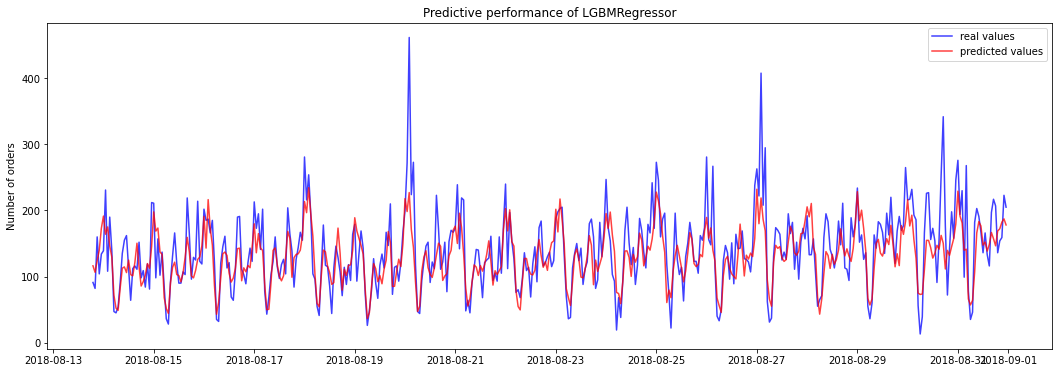

In [152]:
plt.figure(figsize=(18,6))
plt.plot(y_test.index, y_test, label='real values',  color='b', alpha=0.75)
plt.plot(y_test.index, y_pred_lgbm, label='predicted values', color='r', alpha=0.75)
plt.legend()
plt.title('Predictive performance of LGBMRegressor')
plt.ylabel('Number of orders')
plt.show()

Отчетливо видно, что модель способна предсказывать тренд и сезонные изменения, однако она не может предугадать экстремальные значения (например 20 или 27 августа).

### Проверка модели на адекватность

Сравним производительность модели с константной моделью, а также с моделью, которая выдает значение временного ряда на предыдущем шаге.

Начнем с константной модели.

In [139]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)
y_pred_mean = dummy_reg.predict(X_test)
mean_squared_error(y_test, y_pred_mean) ** 0.5

84.72941562076282

Ее производительность значительно хуже. Теперь рассмотрим модель, которая выдает значения на предыдущем шаге.

In [142]:
y_pred_previous = y_test.shift(fill_value=y_train[-1])
mean_squared_error(y_test, y_pred_previous) ** 0.5

59.01904048345839

Производительность модели хуже, чем у обученных моделей. 

- Все обученные модели прошли проверку на адекватность.